In [1]:
%run functions.py

import numpy as np
import pandas as pd
from scipy.io import loadmat

from sklearn.svm import LinearSVC
from sklearn.linear_model import Lasso,ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from warnings import filterwarnings

# Task 1 - Regression 

## Load settings

In [2]:
pd.set_option('display.max_colwidth',-1)
import sys
np.set_printoptions(threshold=sys.maxsize)
filterwarnings('ignore')

k=10 # Define k for crossvalidation
seed = 42 # Seed to use 
feature_tot = 0 # Total selected features -> Start at 0 before PCA
taskname = "task1"
filedir = "/home/fredrik/Documents/Learning_Systems/Labs/Project/"

scoring='neg_mean_squared_error' # Scoring method for GridsearchCV
score_function = f_regression # Score function for Feature selection


np.random.seed(seed) # Define the random seed

In [3]:
# GridSearchCV
estimators = [
    ('clf', 'passthrough'),
]
param_grid = [
    {
        'clf':[SVR()],
        'clf__C':[0.1,10,100],
    },{
        'clf':[Lasso(random_state=seed)],
        'clf__alpha':[0.1,1.0,2.0,5.0],
        'clf__max_iter':[100,1000,5000],

    },{
        'clf':[ElasticNet(random_state=seed)],
        'clf__alpha':[0.1,1.0,2.0,5.0],
        'clf__max_iter':[100,1000,5000],
    },{
        'clf':[RandomForestRegressor(random_state=seed)],  
        'clf__n_estimators':[100,150,200],
        
    },{
        'clf':[MLPRegressor()],
        'clf__hidden_layer_sizes':[(100,20)],
        'clf__activation':['relu'],
        'clf__solver':['adam', 'lbfgs'],
        'clf__alpha':[0.0001,0.001,0.1],
        'clf__max_iter':[200,400],
        'clf__early_stopping':[True, False]
    }
]

## Load dataset

In [4]:
filename = "datasets/cnDieselTrain.mat"

mat = loadmat(filename)
input_train = mat['cnTrainX'].T

target_train = mat['cnTrainY'].reshape(len(input_train))
input_test = mat['cnTestX'].T

## Data info

In [5]:
get_data_info(input_train, target_train)

Length of 133
X.shape: (133, 401) y.shape: (133,)
Contains Nan: False False
Contains +inf: False False
Contains -inf: False False
Input: [[ 6.19124336e-03  5.55355105e-03  4.91585874e-03  4.27816643e-03
   3.64047413e-03  3.00278182e-03  2.45272727e-03  1.86373636e-03
   1.28050909e-03  7.44918182e-04  2.76654545e-04 -1.01172727e-04
  -4.35000000e-04 -8.08572727e-04 -1.31120909e-03 -1.89720909e-03
  -2.44825455e-03 -2.96350000e-03 -3.35212727e-03 -3.56997273e-03
  -3.60011818e-03 -3.47154545e-03 -3.21996364e-03 -2.88049091e-03
  -2.50783636e-03 -2.15782727e-03 -1.86320909e-03 -1.60376364e-03
  -1.38455455e-03 -1.19356364e-03 -1.02395455e-03 -8.69800000e-04
  -7.23400000e-04 -6.00345455e-04 -4.81090909e-04 -3.71918182e-04
  -2.65954545e-04 -1.59854545e-04 -5.21909091e-05  6.44181818e-05
   1.85345455e-04  3.09290909e-04  4.37972727e-04  5.68472727e-04
   6.93781818e-04  8.01936364e-04  8.82318182e-04  9.40445455e-04
   1.00050000e-03  1.06649091e-03  1.13572727e-03  1.20810000e-03
   1.

## Preprocess
Normalize the dataset

In [6]:
input_train, input_test, target_train, input_train_copy, input_train_copy_normalized = preprocessing(input_train,target_train, input_test)

133


## Feature reduction
Reduce dimensionality by PCA transform

In [7]:
feature_tot, pca, pca_input = feature_reduction(input_train, target_train,input_train_copy)

original shape:    (133, 401)
transformed shape: (133, 7)
Explained variance: [0.44006606 0.20850319 0.15866727 0.08548419 0.04025895 0.01514767
 0.00792292]


# Feature extraction

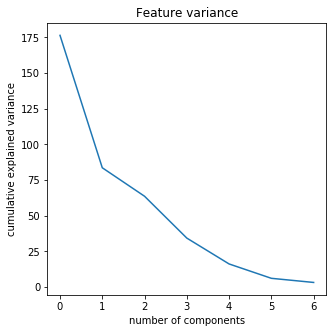

In [8]:
plot_feature_variance(pca_input, filedir=filedir, taskname=taskname)

## Plot top 10 histogram over reduced features

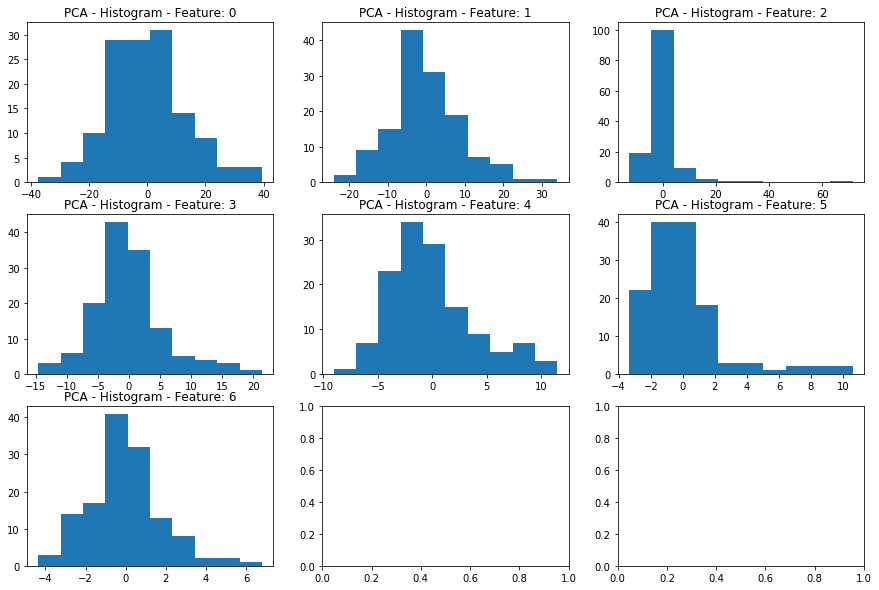

In [9]:
plot_top_features(feature_tot,pca_input, filedir=filedir, taskname=taskname)

# Feature selection
Extract top features above depending on PCA

(133, 401)


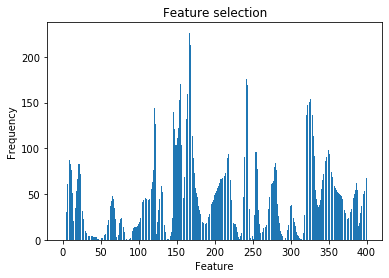

In [10]:
input_train_fs, input_test_fs = feature_selection(score_function, input_train, target_train, input_test, filedir=filedir, taskname=taskname,feature_tot=feature_tot)

## Hyperparameter tuning

In [11]:
# GridSearchCV
grid = parameter_tuning(estimators, param_grid, input_train_fs, target_train, scoring=scoring, k=k)


Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  1.5min finished


## Save model

In [12]:
save_model(grid, filedir=filedir, taskname=taskname)

Save model into: /home/fredrik/Documents/Learning_Systems/Labs/Project/Models/task1.joblib


## Load model

In [13]:
if not grid: 
    grid = load_model(filedir=filedir, taskname=taskname)

## Get Model info

In [14]:
get_model_info(grid)

Best score: -4.908993087999625
Best params {'clf': ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=42, selection='cyclic', tol=0.0001, warm_start=False), 'clf__alpha': 0.1, 'clf__max_iter': 1000}

                                                                                                                                                                                                                                  clf  \
17  ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=0.5,\n           max_iter=1000, normalize=False, positive=False, precompute=False,\n           random_state=42, selection='cyclic', tol=0.0001, warm_start=False)   
16  ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=0.5,\n           max_iter=1000, normalize=False, positive=False, precompute=False,\n           random_state=42, selection='cyclic', tol=0.0001, war

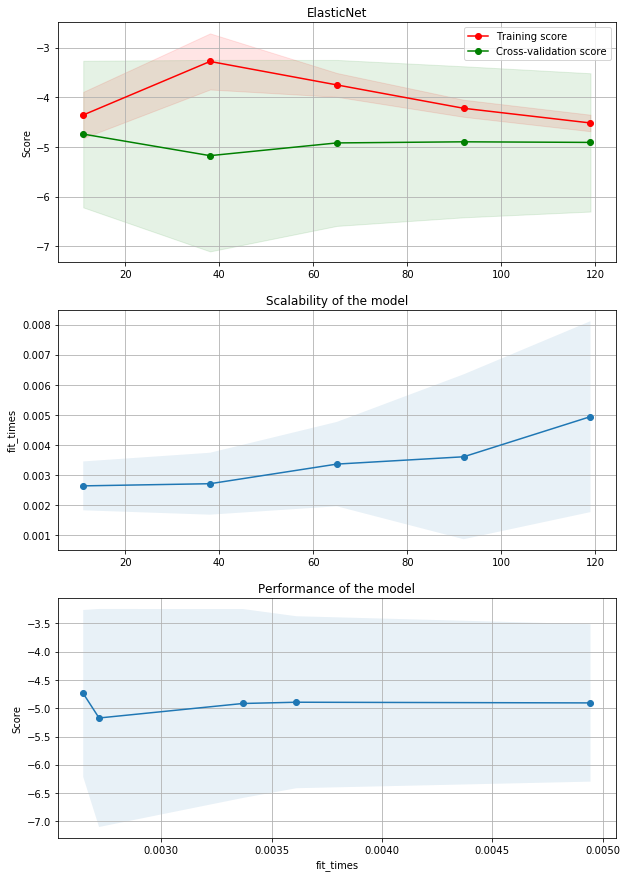

In [15]:
validate_curve(grid, input_train_fs, target_train, filedir=filedir, taskname=taskname,scoring=scoring, k=k)

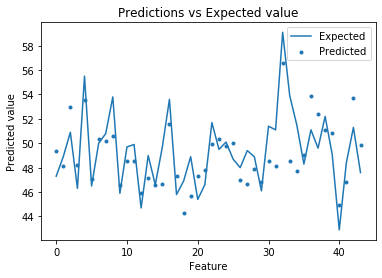

In [16]:
display_model_predict(grid, input_train_fs, target_train, filedir=filedir, taskname=taskname)

# Predict testset

In [17]:
_,predict = predict_model(grid, input_train_fs, target_train, input_test_fs)
print(predict)